loop可视化 可视化第n个loop

In [ ]:
import cooler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 初始化设置
cool_file = '/storu/zkyang/kr_ctcf_untreated.cool'
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

# 设置参数
window_bins = 200  # 224 bins
bin_size = 5000    # 5kb per bin
window_bp = window_bins * bin_size  # 1.12Mb

# 加载cool文件
c = cooler.Cooler(cool_file)

# 读取loop标签文件
loop_file = '/storu/zkyang/hiccups_ENCFF135MUT_CTCF_untreated/merged_loops.bedpe'
loops = pd.read_csv(loop_file, sep='\t')

# 指定要可视化的loop行号（从0开始）
target_loop_index = 117  # 修改这个数字选择不同loop

# 检查行号是否有效
if target_loop_index < 0 or target_loop_index >= len(loops):
    print(f"错误：行号 {target_loop_index} 超出范围 (0-{len(loops)-1})")
else:
    loops = pd.read_csv(loop_file, sep='\t', header=None)
# 取第 target_loop_index 行
    loop = loops.iloc[target_loop_index]
    chrom1, x1, x2, chrom2, y1, y2 = loop[0], loop[1], loop[2], loop[3], loop[4], loop[5]
    if chrom1 == chrom2:
        # 计算中心点和窗口范围
        center = (x1 + x2) // 2
        start = center - window_bp // 2
        end = center + window_bp // 2
        
        # 获取矩阵数据
        try:
            mat = c.matrix(balance='KR').fetch(f'{chrom1}:{start}-{end}')[:window_bins, :window_bins]
            vmax = np.percentile(mat, 98)
            
            # 创建纯净图片（无坐标轴、无标题、无边框）
            plt.figure(figsize=(2.24, 2.24), dpi=300)
            plt.imshow(mat, cmap=fruitpunch, vmax=vmax, aspect='auto')
            
            # 计算并绘制loop矩形框
            loop_x1 = (x1 - start) // bin_size
            loop_x2 = (x2 - start) // bin_size
            loop_y1 = (y1 - start) // bin_size
            loop_y2 = (y2 - start) // bin_size
            
            rect = plt.Rectangle((loop_y1, loop_x1), 
                                loop_y2-loop_y1, 
                                loop_x2-loop_x1,
                                fill=False, 
                                edgecolor='green', 
                                linewidth=3)
            plt.gca().add_patch(rect)
            
            # 去除所有标注和边框
            plt.axis('off')
            plt.gca().set_position([0, 0, 1, 1])  # 去除白边
            plt.show()
            
        except Exception as e:
            print(f"处理loop {target_loop_index} 时出错: {e}")
    else:
        print(f"第 {target_loop_index} 行是跨染色体的loop，已跳过")

loop可视化 可视化第n个loop以及全图loop

In [ ]:
import cooler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 初始化设置
cool_file = '/storu/zkyang/2014gm12878/12878_kr.cool'
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

# 设置参数
window_bins = 224  # 224 bins
bin_size = 5000    # 5kb per bin
window_bp = window_bins * bin_size  # 1.12Mb

# 加载cool文件
c = cooler.Cooler(cool_file)

# 读取loop标签文件
loop_file = '/storu/zkyang/2014gm12878/GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt'
loops = pd.read_csv(loop_file, sep='\t')

# 指定要可视化的loop行号（从0开始）
target_loop_index = 159  # 修改这个数字选择不同loop

# 检查行号是否有效
if target_loop_index < 0 or target_loop_index >= len(loops):
    print(f"错误：行号 {target_loop_index} 超出范围 (0-{len(loops)-1})")
else:
    main_loop = loops.iloc[target_loop_index]
    chrom1, x1, x2, chrom2, y1, y2 = main_loop['chr1'], main_loop['x1'], main_loop['x2'], main_loop['chr2'], main_loop['y1'], main_loop['y2']
    
    if chrom1 == chrom2:
        # 计算主loop的中心点
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # 计算可视化窗口范围
        start_x = center_x - window_bp // 2
        end_x = center_x + window_bp // 2
        start_y = center_y - window_bp // 2 
        end_y = center_y + window_bp // 2
        
        # 获取当前染色体上所有loop
        chrom_loops = loops[(loops['chr1'] == chrom1) & (loops['chr2'] == chrom1)]
        
        # 获取矩阵数据
        try:
            region_x = f'{chrom1}:{start_x}-{end_x}'
            region_y = f'{chrom1}:{start_y}-{end_y}'
            mat = c.matrix(balance=True).fetch(region_x, region_y)[:window_bins, :window_bins]

            # 计算基因组范围内该距离的平均接触概率
            distance = np.abs(np.arange(window_bins)[:, None] - np.arange(window_bins)[None, :])
            avg_contact = np.zeros_like(distance, dtype=float)
            for d in np.unique(distance):
                avg_contact[distance == d] = np.mean(mat[distance == d])

            # 归一化矩阵
            mat = mat / avg_contact
            
           # vmax = np.percentile(mat, 99)
            
            # 创建图片
            plt.figure(figsize=(2.24, 2.24), dpi=100)
            plt.imshow(mat, cmap=fruitpunch, aspect='auto')
            
            # 标注所有在当前窗口内的loop
            for _, loop in chrom_loops.iterrows():
                lx1, lx2 = loop['x1'], loop['x2']
                ly1, ly2 = loop['y1'], loop['y2']
                
                # 计算loop在矩阵中的位置
                loop_x1 = (lx1 - start_x) // bin_size
                loop_x2 = (lx2 - start_x) // bin_size
                loop_y1 = (ly1 - start_y) // bin_size
                loop_y2 = (ly2 - start_y) // bin_size
                
                # 检查是否在可视窗口内
                if (0 <= loop_x1 < window_bins and 0 <= loop_x2 < window_bins and
                    0 <= loop_y1 < window_bins and 0 <= loop_y2 < window_bins):
                    
                    # 主loop用绿色粗框，其他loop用蓝色细框
                    if loop.equals(main_loop):
                        rect = plt.Rectangle(
                            (loop_y1, loop_x1),
                            loop_y2 - loop_y1,
                            loop_x2 - loop_x1,
                            fill=False, 
                            edgecolor='black',
                            linewidth=1
                        )
                    else:
                        rect = plt.Rectangle(
                            (loop_y1, loop_x1),
                            loop_y2 - loop_y1,
                            loop_x2 - loop_x1,
                            fill=False, 
                            edgecolor='black',
                            linewidth=1,
                        )
                    plt.gca().add_patch(rect)
            
            # 去除所有标注和边框
            plt.axis('off')
            plt.gca().set_position([0, 0, 1, 1])
            plt.show()
            
        except Exception as e:
            print(f"处理loop {target_loop_index} 时出错: {e}")
    else:
        print(f"第 {target_loop_index} 行是跨染色体的loop，已跳过")

可视化index 第i张 hic图片

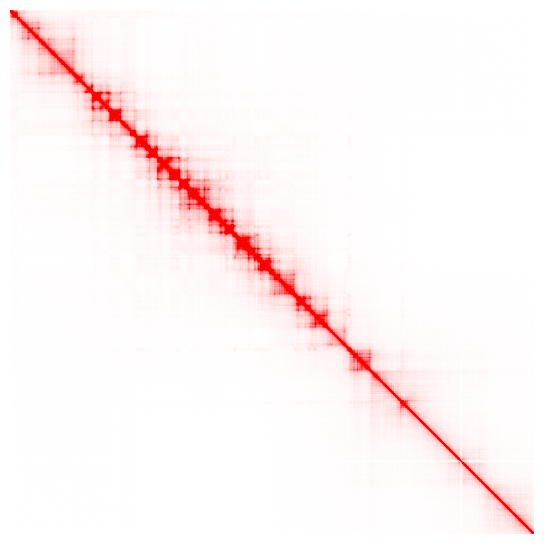

In [18]:
from math import log1p
import cooler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== 初始化设置 =====================
cool_file = '/storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool::/resolutions/5000'
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

# ===================== 参数 =====================
window_size = 3200          # 224 bins
bin_size = 5000            # 5 kb per bin
window_bp = window_size * bin_size  # 1.12 Mb
image_index = 11           # 查看对角线上的第 13 张图片（从 0 开始计数）

# ===================== 加载 cool 文件 =====================
c = cooler.Cooler(cool_file)

# 获取所有染色体列表
chromosomes = c.chromnames

# 选择要可视化的染色体
target_chrom = 'chr1'

# 获取染色体长度
chrom_length = c.chromsizes[target_chrom]

# 计算每个窗口的步长（这里设为窗口大小的 80% 以产生重叠）
step_size = int(window_bp * 1)

# 计算可用的图片总数
num_images = (chrom_length - window_bp) // step_size

# ===================== 可视化第 image_index 个窗口 =====================
if image_index < 0 or image_index >= num_images:
    print(f"错误：图片索引 {image_index} 超出范围 (0-{num_images-1})")
else:
    # 计算当前窗口的起始/结束位置
    start = image_index * step_size
    end = start + window_bp

    try:
        # 获取矩阵数据
        region = f'{target_chrom}:{start}-{end}'
        mat = c.matrix(balance=False).fetch(region)[:window_size, :window_size]
        
        # 可选的距离归一化（保留为注释）
        """
        distance = np.abs(np.arange(window_size)[:, None] - np.arange(window_size)[None, :])
        avg_contact = np.zeros_like(distance, dtype=float)
        for d in np.unique(distance):
            avg_contact[distance == d] = np.mean(mat[distance == d])

        mat = mat / (avg_contact + 1e-12)  # 防止除以 0
        mat = np.log1p(mat)
        """

        # 设置对比度上限
        vmax = np.percentile(mat, 99)

        # 绘图：224px × 224px（2.24 inch @ 100 dpi），去除坐标轴和边框
        plt.figure(figsize=(5.24, 5.24), dpi=100)
        plt.imshow(mat, cmap=fruitpunch, vmax=vmax, aspect='auto')
        plt.axis('off')
        plt.gca().set_position([0, 0, 1, 1])  # 去除白边
        plt.show()
        plt.close()

    except Exception as e:
        print(f"处理图片 {image_index} 时出错: {e}")


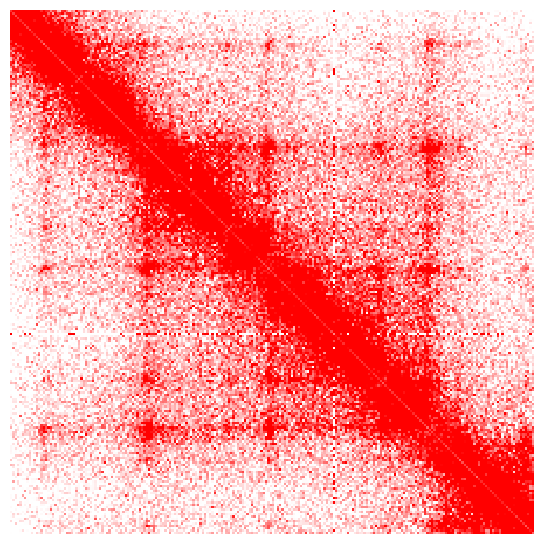

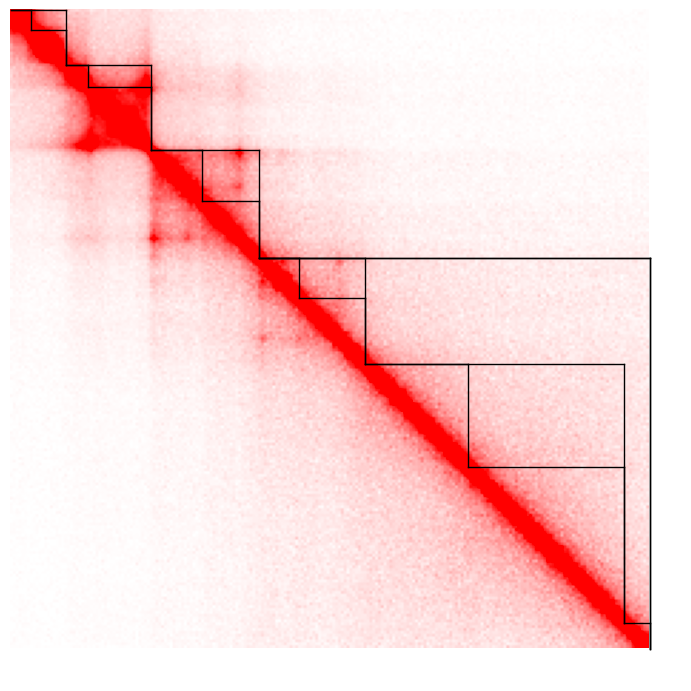

In [ ]:
from math import floor, ceil
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== 路径与参数 =====================
cool_file = '/storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool::/resolutions/5000'
tad_file  = '/storu/zkyang/AAA_MIL/data/tad_ground_truth/HiTAD.bed'  # 支持 3 列或 6 列
cmap = sns.blend_palette(['white', 'red'], as_cmap=True)

window_bins = 224          # 224 bins
bin_size = 5000            # 5 kb
window_bp = window_bins * bin_size  # 1.12 Mb
image_index = 9
step_size = window_bp      # 不重叠（若想重叠: int(window_bp*0.5) 等）

# 你“想看的名字”（写 '1' 或 'chr1' 都行；脚本会映射为文件中的真实命名）
target_chrom_want = '2'

# ===================== 名称与索引的统一工具 =====================
def to_str(x):
    return x.decode('utf-8') if isinstance(x, (bytes, np.bytes_)) else x

def chromnames_str(c):
    return [to_str(n) for n in c.chromnames]

def chromsizes_str(c):
    s = c.chromsizes
    if len(s.index) and isinstance(s.index.values[0], (bytes, np.bytes_)):
        s = s.rename(index=to_str)
    return s

def map_chrom_for_cool(c, want: str) -> str:
    """
    把你给的名字（'1' 或 'chr1'）映射成 .cool/.mcool 里真实存在的名字（统一为 str）。
    """
    names = set(chromnames_str(c))
    if want in names:
        return want
    if want.startswith('chr') and want[3:] in names:
        return want[3:]
    if not want.startswith('chr') and ('chr' + want) in names:
        return 'chr' + want
    raise KeyError(f"{want} not in cooler. Available: {sorted(list(names))[:12]} ...")

def floor_bin(bp, start_bp, bin_size):
    return int(floor((bp - start_bp) / bin_size))

def ceil_bin(bp, start_bp, bin_size):
    # 最小化 0 宽/高：终点用 ceil
    return int(ceil((bp - start_bp) / bin_size))

# ===================== 读 cooler 并统一命名 =====================
c = cooler.Cooler(cool_file)
chrom_len_series = chromsizes_str(c)
real_chrom = map_chrom_for_cool(c, target_chrom_want)     # 映射为文件中的真实命名（'1'）
chrom_length = int(chrom_len_series[real_chrom])

# ===================== 读取 TAD 并把染色体名映射到 cooler 的风格 =====================
# 先读前 6 列（若文件只有 3 列会捕获）
try:
    df = pd.read_csv(tad_file, sep='\t', header=None, comment='#',
                     usecols=[0,1,2,3,4,5],
                     names=['chrom1','x1','x2','chrom2','y1','y2'],
                     
                     )
    mode6 = True
except Exception:
    # 退化为 3 列
    df = pd.read_csv(tad_file, sep='\t', header=None, comment='#',
                     usecols=[0,1,2],
                     names=['chrom','start','end'],
                     )
    mode6 = False

# 规范化 BED 染色体名到 cooler 的命名集合
names_set = set(chromnames_str(c))
def map_name_to_cool(n):
    n = to_str(n)
    if n in names_set:
        return n
    if n.startswith('chr') and n[3:] in names_set:
        return n[3:]
    if not n.startswith('chr') and ('chr'+n) in names_set:
        return 'chr'+n
    # 丢掉映射失败的行
    return None

if mode6:
    df['chrom1'] = df['chrom1'].map(map_name_to_cool)
    df['chrom2'] = df['chrom2'].map(map_name_to_cool)
    df = df.dropna(subset=['chrom1','chrom2'])
    # 只保留 cis，且是目标染色体
    tads_chr = df[(df['chrom1'] == df['chrom2']) & (df['chrom1'] == real_chrom)].copy()
    tads_chr = tads_chr.sort_values(['x1','x2','y1','y2']).reset_index(drop=True)
else:
    df['chrom'] = df['chrom'].map(map_name_to_cool)
    df = df.dropna(subset=['chrom'])
    # 3 列视为对角线 TAD：x 区间 = y 区间
    tads_chr = df[df['chrom'] == real_chrom].copy()
    tads_chr.rename(columns={'start':'x1','end':'x2'}, inplace=True)
    tads_chr['y1'] = tads_chr['x1']
    tads_chr['y2'] = tads_chr['x2']
    tads_chr = tads_chr[['x1','x2','y1','y2']].sort_values(['x1','x2']).reset_index(drop=True)

# ===================== 计算窗口并可视化 =====================
num_images = max(1, (chrom_length - window_bp) // step_size)
if image_index < 0 or image_index >= num_images:
    print(f"错误：图片索引 {image_index} 超出范围 (0-{max(0, num_images-1)})")
else:
    start = image_index * step_size
    end   = min(start + window_bp, chrom_length)

    try:
        region = f'{real_chrom}:{start}-{end}'
        mat = c.matrix(balance=True).fetch(region)[:window_bins, :window_bins]

        vmax = float(np.percentile(mat, 96))
        plt.figure(figsize=(6.72, 6.72), dpi=100)
        ax = plt.gca()
        ax.imshow(mat, cmap=cmap, vmax=vmax, aspect='auto', origin='upper')

        # 取与窗口相交的 TAD
        mask = (tads_chr['x2'] > start) & (tads_chr['x1'] < end) & \
               (tads_chr['y2'] > start) & (tads_chr['y1'] < end)
        tads_win = tads_chr[mask].copy()

        for _, row in tads_win.iterrows():
            # 起点用 floor、终点用 ceil
            x1b = floor_bin(max(row['x1'], start), start, bin_size)
            x2b = ceil_bin(min(row['x2'], end),   start, bin_size)
            y1b = floor_bin(max(row['y1'], start), start, bin_size)
            y2b = ceil_bin(min(row['y2'], end),   start, bin_size)

            # 裁剪
            x1b = max(0, min(window_bins, x1b))
            x2b = max(0, min(window_bins, x2b))
            y1b = max(0, min(window_bins, y1b))
            y2b = max(0, min(window_bins, y2b))

            if x2b <= x1b or y2b <= y1b:
                continue

            # === 只画上三角边框 ===
            # 即画方框的上边、右边两条线
            ax.plot([y1b, y2b], [x1b, x1b], color='black', linewidth=1.0)   # 上边
            ax.plot([y2b, y2b], [x1b, x2b], color='black', linewidth=1.0)   # 右边

        ax.axis('off')
        ax.set_position([0, 0, 1, 1])
        plt.show()
        plt.close()

    except Exception as e:
        print(f"处理图片 {image_index} 时出错: {e}")


In [3]:
# 必需：pip install cooler h5py numpy pandas matplotlib

from math import floor, ceil
import os, re, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cooler

# ============== 路径与参数（按需修改） ==============
# 写法1：纯 .mcool 路径 -> 自动选择 desired_bin_size 或最近分辨率
# 写法2：.mcool::/resolutions/5000 -> 直接使用该分辨率
# 写法3：纯 .cool 路径 -> 使用文件内分辨率
base_cool_path   = '/storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool'
desired_bin_size = 5000   # 例如 1000 或 5000
stripes_file     = '/storu/zkyang/2014gm12878/stripenn/out/result_unfiltered.tsv'

# 视觉/窗口
window_bins      = 500       # 每张图 N×N bin
image_index      = 1         # 第几幅窗口图（0 起）
step_in_windows  = 1.0       # 窗口步长（单位=窗口），1.0=不重叠，0.5=50%重叠
fig_size_inch    = 6.72
dpi              = 100

# 目标染色体（'1' 或 'chr1' 都行）
target_chrom_want = '4'

# 线条标注
draw_symmetric   = True  # 是否同时画对称线
line_width       = 1.5   # 线宽
one_based_input  = True  # 你的 TSV 一般是 1-based 闭区间；若是 0-based 半开区间就改成 False


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

使用分辨率: 10000 bp  |  URI: /storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool::/resolutions/10000
可视窗口数: 94  |  image_index=1
Region: chr4:2000000-4000000


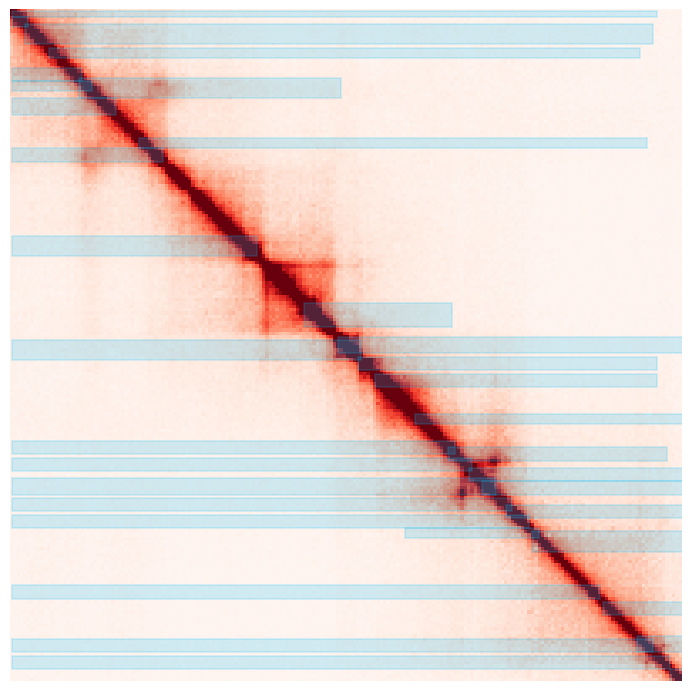

In [23]:
# %%  Notebook cell: 用 mcool + Stripenn 结果画“竖直矩形条带”（仿 example_call.png）
from math import floor, ceil
import h5py
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt

# ===================== 路径与参数（按需修改） =====================
base_cool_path   = '/storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool'
desired_bin_size = 10000             # 例如 1000 或 5000
stripes_file     = '/storu/zkyang/2014gm12878/stripenn/out/result_unfiltered.tsv'

# TSV 坐标制（Stripenn 常见为 1-based 闭区间）
tsv_one_based_closed = True         # 若你的表是 0-based 半开，则改为 False

# 视野与显示
target_chrom_want = '4'             # '4' 或 'chr4' 都行
window_bins       = 200             # 窗口的 bin×bin
step_in_windows   = 1.0             # 1.0=不重叠；0.5=50% 重叠
image_index       = 1               # 看第几张窗口（0 起）
cmap_name         = 'Reds'          # 纯 matplotlib，避免额外依赖

# 叠加样式
draw_symmetric_box = False           # 是否同时画对称矩形（便于看上下三角一致性）
draw_full_box      = True           # True=画四边且半透明填充；False=只画上边与右边（线框）
face_alpha         = 0.18           # 矩形填充透明度
edge_color         = 'deepskyblue'
edge_width         = 1.2

# ===================== 小工具 =====================
def to_str(x):
    return x.decode('utf-8') if isinstance(x, (bytes, np.bytes_)) else x

def chromnames_str(c):
    return [to_str(n) for n in c.chromnames]

def chromsizes_str(c):
    s = c.chromsizes
    if len(s.index) and isinstance(s.index.values[0], (bytes, np.bytes_)):
        s = s.rename(index=to_str)
    return s

def map_chrom_for_cool(c, want: str) -> str:
    names = set(chromnames_str(c))
    if want in names: return want
    if want.startswith('chr') and want[3:] in names: return want[3:]
    if not want.startswith('chr') and ('chr'+want) in names: return 'chr'+want
    raise KeyError(f"{want} not in cooler. 可用: {sorted(list(names))[:12]} ...")

def floor_bin(bp, start_bp, bin_size):
    return int(floor((bp - start_bp) / bin_size))

def ceil_bin(bp, start_bp, bin_size):
    return int(ceil((bp - start_bp) / bin_size))

def is_cool_uri(path: str) -> bool:
    return '::' in path

def resolve_cool_uri(path_or_uri: str, want_binsize: int):
    # 兼容 .cool / .mcool / .mcool::/resolutions/N
    if is_cool_uri(path_or_uri):
        c = cooler.Cooler(path_or_uri);  return path_or_uri, int(c.binsize)
    if path_or_uri.endswith('.cool'):
        c = cooler.Cooler(path_or_uri);  return path_or_uri, int(c.binsize)
    if path_or_uri.endswith('.mcool'):
        with h5py.File(path_or_uri, 'r') as f:
            if 'resolutions' not in f: raise RuntimeError("该 .mcool 不含 '/resolutions'")
            avail = []
            for k in f['/resolutions'].keys():
                try: avail.append(int(k))
                except: pass
        if not avail: raise RuntimeError("'/resolutions' 下没有整数分辨率")
        avail = sorted(avail)
        chosen = want_binsize if want_binsize in avail else min(avail, key=lambda x: abs(x-want_binsize))
        if chosen != want_binsize:
            print(f"[提示] 未找到 {want_binsize}bp，改用最近的 {chosen}bp")
        return f"{path_or_uri}::/resolutions/{chosen}", int(chosen)
    raise ValueError("仅支持 .cool / .mcool / .mcool::/resolutions/N")

def read_stripes(path):
    cols = ["chr","pos1","pos2","chr2","pos3","pos4","length","width","Mean","maxpixel","pvalue","Stripiness"]
    try:
        df = pd.read_csv(path, sep=r"\s+", engine="python")
        if "chr" not in df.columns or "pos1" not in df.columns:
            df = pd.read_csv(path, sep=r"\s+", engine="python", names=cols)
    except Exception:
        df = pd.read_csv(path, sep=r"\s+", engine="python", names=cols)
    # 清洗 & 数值化
    for c in ["pos1","pos2","pos3","pos4","length","width","Mean","Stripiness"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if "maxpixel" in df.columns:
        df["maxpixel"] = df["maxpixel"].astype(str).str.replace("%","", regex=False)
        df["maxpixel"] = pd.to_numeric(df["maxpixel"], errors="coerce")
    # 仅保留 cis
    if "chr2" in df.columns: df = df[df["chr"] == df["chr2"]].copy()
    return df

# ===================== 解析 cooler，准备窗口 =====================
cool_uri, bin_size = resolve_cool_uri(base_cool_path, desired_bin_size)
print(f"使用分辨率: {bin_size} bp  |  URI: {cool_uri}")

c = cooler.Cooler(cool_uri)
chrom_len_series = chromsizes_str(c)
real_chrom = map_chrom_for_cool(c, target_chrom_want)
chrom_length = int(chrom_len_series[real_chrom])

window_bp = window_bins * bin_size
step_size = int(round(window_bp * step_in_windows))
num_images = max(1, (chrom_length - window_bp) // step_size)
print(f"可视窗口数: {num_images}  |  image_index={image_index}")

if image_index < 0 or image_index >= num_images:
    raise ValueError(f"image_index {image_index} 超出范围 (0 ~ {max(0, num_images-1)})")

start = image_index * step_size
end   = min(start + window_bp, chrom_length)
region = f'{real_chrom}:{start}-{end}'
print("Region:", region)

# ===================== 读条纹并映射染色体命名 =====================
stripes = read_stripes(stripes_file)
names_set = set(chromnames_str(c))

def map_name_to_cool(n):
    n = to_str(n)
    if n in names_set: return n
    if n.startswith('chr') and n[3:] in names_set: return n[3:]
    if not n.startswith('chr') and ('chr'+n) in names_set: return 'chr'+n
    return None

stripes["chr"]  = stripes["chr"].map(map_name_to_cool)
if "chr2" in stripes.columns: stripes["chr2"] = stripes["chr2"].map(map_name_to_cool)
else: stripes["chr2"] = stripes["chr"]
stripes = stripes.dropna(subset=["chr","chr2"])
stripes_chr = stripes[(stripes["chr"] == stripes["chr2"]) & (stripes["chr"] == real_chrom)].copy()
stripes_chr = stripes_chr.sort_values(["pos1","pos2","pos3","pos4"]).reset_index(drop=True)

# === 坐标换算（1-based 闭区间 -> 0-based 半开；如果本来就是 0-based 半开，直接用原值） ===
def start0(p):  return int(p) - 1 if tsv_one_based_closed else int(p)   # 起点
def end0(p):    return int(p)       if tsv_one_based_closed else int(p) # 终点（半开右端）

# ===================== 取矩阵并叠加条纹矩形 =====================
mat = c.matrix(balance=True).fetch(region)[:window_bins, :window_bins]
vmax = float(np.nanpercentile(mat, 98))

plt.figure(figsize=(6.72, 6.72), dpi=100)
ax = plt.gca()
ax.imshow(mat, cmap=cmap_name, vmax=vmax, aspect='auto', origin='upper')

# 筛选落入窗口的条纹（两个轴都要相交）
mask = (stripes_chr['pos2'] > start) & (stripes_chr['pos1'] < end) & \
       (stripes_chr['pos4'] > start) & (stripes_chr['pos3'] < end)
stripes_win = stripes_chr[mask].copy()

for _, r in stripes_win.iterrows():
    # 将 pos1..pos4 转为 0-based 半开（bp）
    X1 = start0(r['pos1']); X2 = end0(r['pos2'])   # x 方向（宽度）
    Y1 = start0(r['pos3']); Y2 = end0(r['pos4'])   # y 方向（长度）

    # 映射到窗口的 bin 坐标
    x1b = floor_bin(max(X1, start), start, bin_size)
    x2b = ceil_bin(min(X2, end),   start, bin_size)
    y1b = floor_bin(max(Y1, start), start, bin_size)
    y2b = ceil_bin(min(Y2, end),   start, bin_size)

    # 裁剪
    x1b = max(0, min(window_bins, x1b))
    x2b = max(0, min(window_bins, x2b))
    y1b = max(0, min(window_bins, y1b))
    y2b = max(0, min(window_bins, y2b))
    if x2b <= x1b or y2b <= y1b: 
        continue

    if draw_full_box:
        # 半透明填充 + 四边
        from matplotlib.patches import Rectangle
        rect = Rectangle((y1b, x1b), (y2b - y1b), (x2b - x1b),
                         linewidth=edge_width, edgecolor=edge_color,
                         facecolor=edge_color, alpha=face_alpha)
        ax.add_patch(rect)
        # 可选：对称矩形（水平 ↔ 竖直 互换）
        if draw_symmetric_box:
            rectT = Rectangle((x1b, y1b), (x2b - x1b), (y2b - y1b),
                              linewidth=max(1.0, edge_width-0.2), edgecolor=edge_color,
                              facecolor=edge_color, alpha=face_alpha*0.7, linestyle='--')
            ax.add_patch(rectT)
    else:
        # 只画“上边 + 右边”线框（和你 TAD 代码类似）
        ax.plot([y1b, y2b], [x1b, x1b], color=edge_color, linewidth=edge_width)  # 上边
        ax.plot([y2b, y2b], [x1b, x2b], color=edge_color, linewidth=edge_width)  # 右边
        if draw_symmetric_box:
            ax.plot([x1b, x2b], [y1b, y1b], color=edge_color, linewidth=edge_width, linestyle='--')
            ax.plot([x2b, x2b], [y1b, y2b], color=edge_color, linewidth=edge_width, linestyle='--')

ax.axis('off')
ax.set_position([0, 0, 1, 1])
plt.show()
plt.close()


使用分辨率: 5000 bp | URI: /storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool::/resolutions/5000
Region = chr21:41870000-43090000 | margin = 250 kb | 条纹宽×长（bp）= 50,000 × 720,000
映射到 bin：x[50,60) × y[50,194) | width=10 bin, length=144 bin


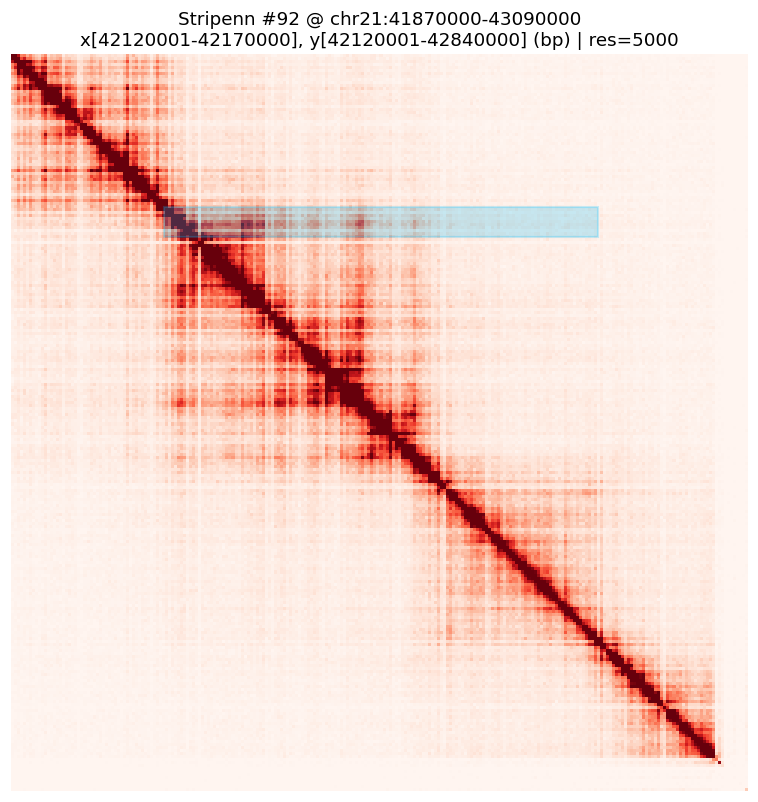

In [34]:
# %% 可直接运行：按 stripenn_index 可视化指定条纹（竖直矩形条带）
# 依赖：cooler, h5py, numpy, pandas, matplotlib
from math import floor, ceil
import h5py, numpy as np, pandas as pd, cooler
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ===================== 路径与参数（按需修改） =====================
mcool_path            = '/storu/zkyang/2014data/data/Rao2014/Rao2014_GM12878.mcool'  # .mcool 或 .mcool::/resolutions/N 或 .cool
desired_bin_size_bp   = 5000      # 若给的是纯 .mcool，会在 /resolutions 里选最近的
stripes_tsv_path      = '/storu/zkyang/2014gm12878/stripenn/out/result_filtered.tsv'

stripenn_index        = 92        # << 写第几条（“第16个”），默认按 1 起始
index_is_one_based    = True      # True=上述索引从1开始；False=从0开始

tsv_one_based_closed  = True      # Stripenn 输出一般是 1-based 闭区间；若是 0-based 半开，改 False
balance_matrix        = False      # 用 cooler 的 balanced 矩阵
draw_symmetric_box    = False      # 是否画对称矩形（看上下三角一致性）
fill_alpha            = 0.22      # 矩形填充透明度（0=只边框）  
edge_color            = 'deepskyblue'
edge_width            = 1.4
cmap_name             = 'Reds'    # 纯 matplotlib colormap
vmax_percentile       = 98        # 热图上限用分位数

# 如果想强制指定染色体（一般不需要，Stripenn 行里自带 chr），可以写成 '1' 或 'chr1'
force_target_chrom    = None      # 例如 '4' 或 'chr4'；None 表示用该条纹自己的 chr

# margin 策略：默认为 max(250kb, 25%*length)，也可以手动覆盖
margin_bp_override    = None      # 例如 400_000；None=使用自动策略

# ===================== 小工具 =====================
def resolve_cool_uri(path_or_uri: str, want_binsize: int):
    """支持 .cool / .mcool / .mcool::/resolutions/N"""
    if '::' in path_or_uri:
        c = cooler.Cooler(path_or_uri)
        return path_or_uri, int(c.binsize)
    if path_or_uri.endswith('.cool'):
        c = cooler.Cooler(path_or_uri)
        return path_or_uri, int(c.binsize)
    if path_or_uri.endswith('.mcool'):
        with h5py.File(path_or_uri, 'r') as f:
            if 'resolutions' not in f:
                raise RuntimeError("该 .mcool 不含 '/resolutions'")
            avail = sorted(int(k) for k in f['/resolutions'].keys())
        if not avail:
            raise RuntimeError("'/resolutions' 下没有整数分辨率")
        chosen = want_binsize if want_binsize in avail else min(avail, key=lambda x: abs(x - want_binsize))
        if chosen != want_binsize:
            print(f"[提示] 未找到 {want_binsize}bp，改用最近的 {chosen}bp")
        return f"{path_or_uri}::/resolutions/{chosen}", int(chosen)
    raise ValueError("仅支持 .cool / .mcool / .mcool::/resolutions/N")

def to_str(x):
    import numpy as _np
    return x.decode('utf-8') if isinstance(x, (bytes, _np.bytes_)) else x

def map_chrom_name(c, want: str) -> str:
    names = [to_str(n) for n in c.chromnames]
    if want in names: return want
    if want.startswith('chr') and want[3:] in names: return want[3:]
    if (not want.startswith('chr')) and ('chr'+want) in names: return 'chr'+want
    raise KeyError(f"{want} not in cooler names: {names[:12]} ...")

def floor_bin(bp, start_bp, bin_size):
    return int(floor((bp - start_bp) / bin_size))

def ceil_bin(bp, start_bp, bin_size):
    return int(ceil((bp - start_bp) / bin_size))

def read_stripenn_tsv(path):
    """尽量兼容：空白分隔、有/无表头；保留必须列。"""
    want = ["chr","pos1","pos2","chr2","pos3","pos4","length","width","Mean","maxpixel","pvalue","Stripiness"]
    try:
        df = pd.read_csv(path, sep=r"\s+", engine="python")
        if "chr" not in df.columns or "pos1" not in df.columns:
            df = pd.read_csv(path, sep=r"\s+", engine="python", names=want)
    except Exception:
        df = pd.read_csv(path, sep=r"\s+", engine="python", names=want)
    # 只保留 cis
    if "chr2" in df.columns:
        df = df[df["chr"] == df["chr2"]].copy()
    # 清洗
    for c in ["pos1","pos2","pos3","pos4","length","width","Mean","Stripiness"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if "maxpixel" in df.columns:
        df["maxpixel"] = df["maxpixel"].astype(str).str.replace("%","", regex=False)
        df["maxpixel"] = pd.to_numeric(df["maxpixel"], errors="coerce")
    df = df.dropna(subset=["chr","pos1","pos2","pos3","pos4"]).reset_index(drop=True)
    return df

# ===================== 读取数据 =====================
cool_uri, binsize = resolve_cool_uri(mcool_path, desired_bin_size_bp)
print(f"使用分辨率: {binsize} bp | URI: {cool_uri}")
clr = cooler.Cooler(cool_uri)

df = read_stripenn_tsv(stripes_tsv_path)
if len(df) == 0:
    raise RuntimeError("TSV 为空或未解析到必需字段。")

# 索引换算（默认 1 起）
row_idx = (stripenn_index - 1) if index_is_one_based else stripenn_index
if not (0 <= row_idx < len(df)):
    raise IndexError(f"stripenn_index 越界：共有 {len(df)} 条，索引={stripenn_index}（{'1-based' if index_is_one_based else '0-based'}）")

row = df.iloc[row_idx].copy()

# 染色体命名映射（可强制替换）
chrom_raw = row["chr"]
if force_target_chrom is not None:
    chrom_raw = force_target_chrom
chrom = map_chrom_name(clr, str(chrom_raw))
chrom2 = map_chrom_name(clr, str(row.get("chr2", chrom_raw)))
assert chrom == chrom2, "此示例仅演示 cis 条纹"

# 1-based 闭区间 → 0-based 半开
def s0(p): return int(p) - 1 if tsv_one_based_closed else int(p)  # 起点
def e0(p): return int(p)       if tsv_one_based_closed else int(p)  # 终点（半开右端）

X1, X2 = s0(row["pos1"]), e0(row["pos2"])   # x 方向（横轴，宽度）
Y1, Y2 = s0(row["pos3"]), e0(row["pos4"])   # y 方向（纵轴，长度）

# 自动 margin（或使用覆盖值）
length_bp = int(row["pos4"]) - int(row["pos3"]) + (1 if tsv_one_based_closed else 0)
margin_bp = margin_bp_override if margin_bp_override is not None else max(250_000, int(0.25 * length_bp))

# 取窗口（左右取 min/max，再加 margin）
start_bp = max(0, min(X1, Y1) - margin_bp)
end_bp   = max(X2, Y2) + margin_bp
# Clamp 到染色体长度
chrom_len = int(clr.chromsizes.loc[chrom])
end_bp = min(end_bp, chrom_len)

region = f"{chrom}:{start_bp}-{end_bp}"
print(f"Region = {region} | margin = {margin_bp/1e3:.0f} kb | 条纹宽×长（bp）= {(X2-X1):,} × {(Y2-Y1):,}")

# ===================== 取矩阵并作图 =====================
mat = clr.matrix(balance=balance_matrix).fetch(region)
vmax = float(np.nanpercentile(mat, vmax_percentile))

plt.figure(figsize=(6.7,6.7), dpi=110)
ax = plt.gca()
ax.imshow(mat, cmap=cmap_name, vmax=vmax, origin='upper', aspect='auto')
ax.set_title(f"Stripenn #{stripenn_index} @ {region}\n"
             f"x[{row['pos1']}-{row['pos2']}], y[{row['pos3']}-{row['pos4']}] (bp) | res={binsize}")

# 把条纹矩形从 bp 映射到窗口的 bin 坐标
x1b = floor_bin(max(X1, start_bp), start_bp, binsize)
x2b = ceil_bin (min(X2, end_bp),   start_bp, binsize)
y1b = floor_bin(max(Y1, start_bp), start_bp, binsize)
y2b = ceil_bin (min(Y2, end_bp),   start_bp, binsize)

# 裁剪到窗口大小
H, W = mat.shape
x1b = max(0, min(W, x1b)); x2b = max(0, min(W, x2b))
y1b = max(0, min(H, y1b)); y2b = max(0, min(H, y2b))

print(f"映射到 bin：x[{x1b},{x2b}) × y[{y1b},{y2b}) | width={x2b-x1b} bin, length={y2b-y1b} bin")

# 画“竖直矩形条带”（半透明填充）
rect = Rectangle((y1b, x1b), (y2b - y1b), (x2b - x1b),
                 linewidth=edge_width, edgecolor=edge_color,
                 facecolor=edge_color, alpha=fill_alpha)
ax.add_patch(rect)

# （可选）画对称矩形
if draw_symmetric_box:
    rectT = Rectangle((x1b, y1b), (x2b - x1b), (y2b - y1b),
                      linewidth=max(1.0, edge_width-0.2), edgecolor=edge_color,
                      facecolor=edge_color, alpha=fill_alpha*0.85, linestyle='--')
    ax.add_patch(rectT)

ax.axis('off'); ax.set_position([0,0,1,1])
plt.show()
plt.close()


In [ ]:
# 可视化 TAD 边界（IS 导出的 BED）叠加到 10kb Hi-C 热图
# 依赖：cooler, numpy, pandas, matplotlib
import numpy as np, pandas as pd, cooler
import matplotlib.pyplot as plt
from math import floor, ceil

# ================== 路径与参数 ==================
mcool_path = '/storu/zkyang/AAA_MIL/data/12878.mcool::/resolutions/10000'
bed_path   = '/storu/zkyang/AAA_MIL/tad/tad_boundaries_is_10kb.bed'   # chrom start end
chrom      = '1'        # 例如 '1' 或 'chr1'，会自动映射
start_bp   = 20_000_000 # 可改
end_bp     = 30_000_000 # 可改
balance    = True       # 使用平衡矩阵（KR/ICE）
vmax_pct   = 98         # 可视化上限分位数
line_color = 'deepskyblue'
line_width = 0.8

# ================== 小工具 ==================
def to_str(x):
    import numpy as _np
    return x.decode('utf-8') if isinstance(x, (bytes, _np.bytes_)) else x

def map_chrom_name(c, want: str) -> str:
    names = [to_str(n) for n in c.chromnames]
    if want in names: return want
    if want.startswith('chr') and want[3:] in names: return want[3:]
    if (not want.startswith('chr')) and ('chr'+want) in names: return 'chr'+want
    raise KeyError(f"{want} not in cooler names: {names[:12]} ...")

# ================== 读取矩阵与边界 ==================
clr = cooler.Cooler(mcool_path)
chrom = map_chrom_name(clr, str(chrom))
region = f"{chrom}:{start_bp}-{end_bp}"
mat = clr.matrix(balance=balance).fetch(region)

# 可视化裁剪
vmax = float(np.nanpercentile(mat, vmax_pct)) if np.isfinite(mat).any() else 1.0
plt.figure(figsize=(6.8,6.8), dpi=120)
ax = plt.gca()
im=ax.imshow(mat, origin='upper', cmap='Reds', vmax=vmax, aspect='auto')
ax.set_title(f"Hi-C heatmap @10kb | {region}
Overlay: IS boundaries ({bed_path.split('/')[-1]})")
ax.axis('off')

# 边界加载与筛选
cols=['chrom','start','end']
bed = pd.read_csv(bed_path, sep='	', header=None, names=cols, dtype={0:str,1:int,2:int})
# 名称映射
bed['chrom']=bed['chrom'].astype(str)
if chrom.startswith('chr'):
    # 期望 'chr1' 风格
    bed['chrom'] = bed['chrom'].apply(lambda x: x if x.startswith('chr') else 'chr'+x)
else:
    # 期望 '1' 风格
    bed['chrom'] = bed['chrom'].apply(lambda x: x[3:] if x.startswith('chr') else x)

sub = bed[(bed['chrom']==chrom) & (bed['start']<end_bp) & (bed['end']>start_bp)].copy()

# 映射到本窗口的 bin 坐标（10kb）
binsize = int(clr.binsize)
# H==W 正方形
H, W = mat.shape

# 对每个边界位置画横/纵线（与对角对应）
for _, r in sub.iterrows():
    # 用区间起点代表边界位置
    b_bp = max(start_bp, r['start'])
    b_idx = int((b_bp - start_bp) // binsize)
    if 0 <= b_idx < W:
        ax.axvline(b_idx, color=line_color, lw=line_width, alpha=0.9)
        ax.axhline(b_idx, color=line_color, lw=line_width, alpha=0.9)

plt.show(); plt.close()
